In [1073]:
# !pip install PyPortfolioOpt==1.2.5 
# !pip install cvxpy==1.1
# !pip install --upgrade firebase-admin
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
#style.use('fivethirtyeight')  k chay
import seaborn as sns
pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize':(10,6)})
%config InlineBackend.figure_format = 'retina'


In [1074]:
import pandas as pd
portfolio_api = pd.read_json("https://danhmuc.herokuapp.com/lists/1/risk_analysis.json")
rails = pd.DataFrame(portfolio_api)
tickers = []
for i in range(len(rails.security)):
  tickers.append(rails.security[i]['ticker'])
tickers 
portfolio_api.list_id.unique().tolist()
print(portfolio_api)

    id  security_id  list_id                       created_at  \
0  202          220        1 2020-09-08 09:34:27.573000+07:00   
1  204          389        1 2020-09-08 09:34:39.228000+07:00   
2  205           86        1 2020-09-08 09:45:41.193000+07:00   
3  208          155        1 2020-09-08 15:46:42.629000+07:00   

                        updated_at  price  signal  quantity           security  
0 2020-09-08 09:34:27.573000+07:00  22750     NaN        10  {'ticker': 'NT2'}  
1 2020-09-08 09:34:39.228000+07:00  33600     NaN        10  {'ticker': 'VSC'}  
2 2020-09-08 09:45:41.193000+07:00  16100     NaN        10  {'ticker': 'DPM'}  
3 2020-09-08 15:46:42.629000+07:00  24600     NaN        10  {'ticker': 'HPG'}  


In [1075]:
start_date = '2013-01-01'
stock_list = tickers
#stock_list = [ 'VCB', 'MWG', 'ROS', 'FPT', 'NVL', 'CTD']
stock_list = ['PNJ', 'VIC', 'FPT', 'VCB', 'MWG'] #'MWG', 'HPG', 'PNJ', 'REE', 'FPT'
#stock_list = [ 'VCB', 'CTG', 'BID', 'ACB', 'MBB', 'SHB'] # underperform
#stock_list = ["BID", "BVH", "CTD", "CTG", "EIB", "FPT", "GAS", "HDB", "HPG", "MBB", "MSN", "MWG", "NVL", "PLX", "PNJ", "POW", "REE", "ROS", "SAB", "SBT", "SSI", "STB", "TCB", "VCB", "VHM", "VIC", "VJC", "VNM", "VPB", "VRE"]
numstocks = len(stock_list)
data_index = pd.read_csv('/content/drive/My Drive/data_analyst/data_index2012.csv')
data_index = data_index[['Ticker', 'Date', 'Close', 'AdjRatio']] #, 'Shares'
data_index['Date'] = pd.to_datetime(data_index['Date'], format='%Y-%m-%d')
data_index = data_index[ (data_index.Ticker.isin(stock_list)) & (data_index['Date'] >= start_date) ] #& (data_index['Date'] < '2020-04-01')
data_index['Adj_Close'] = data_index['Close'] / data_index['AdjRatio']
#data_index['Mcap'] = data_index['Close'] * data_index['Shares']
print(data_index.tail(5))

#pivot
data_index_pivot = data_index.pivot(columns='Ticker', index='Date', values='Adj_Close')
returns = data_index_pivot.pct_change()
avg_daily_return = returns.mean()

        Ticker       Date    Close  AdjRatio  Adj_Close
2428868    FPT 2020-08-24  48450.0       1.0    48450.0
2429275    MWG 2020-08-24  84100.0       1.0    84100.0
2429424    PNJ 2020-08-24  58600.0       1.0    58600.0
2429883    VCB 2020-08-24  83900.0       1.0    83900.0
2429937    VIC 2020-08-24  89000.0       1.0    89000.0


In [1076]:
%%time
#%%timeit -r 1 -n 20
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import CLA

EOM  = data_index_pivot.copy()
EOM_resample = EOM.resample('BMS').ffill()  #BQ business quarter end, BQS business quarter start, BMS month start
reb_date = list(EOM.resample('BMS').ffill().index)
#last reb là ngày cuối quý trước
if reb_date[-1] > pd.Timestamp.today():
  reb_date.pop()
weights_dfs = pd.DataFrame()
weights_RP_dfs = pd.DataFrame()
for i in range(24,len(reb_date)):
    print(reb_date[i])
    df = EOM.loc[:reb_date[i]].dropna(axis='columns', thresh=300).tail(100)
    
    risk_parity_weights = get_weights(df)
    risk_parity_weights_df = pd.DataFrame(risk_parity_weights).reset_index().rename(columns={'weight': 'weights_RP'})
    risk_parity_weights_df['Date'] = reb_date[i]
    weights_RP_dfs = weights_RP_dfs.append(risk_parity_weights_df)  
    
    print(df.head(1))
    print('last row cum return==============')
    print( ((df.pct_change() + 1).cumprod() -1).tail(1) )
    if ((((df.pct_change() + 1).cumprod() -1).tail(1)).sum(axis=1)).iloc[0] >0.01:
      print("--total return {}".format(((((df.pct_change() + 1).cumprod() -1).tail(1)).sum(axis=1)).iloc[0]))
      try:
        mu = expected_returns.mean_historical_return(df)
        S = risk_models.sample_cov(df)
          # Optimise for maximal Sharpe ratio
        ef = EfficientFrontier(mu, S, weight_bounds=(0,0.8))   
          #ef.add_constraint(lambda x : x >= 0.01)
        raw_weights = ef.max_sharpe()
        cleaned_weights = ef.clean_weights()
        print(cleaned_weights)
        ef.portfolio_performance(verbose=True)
        weights_df = pd.DataFrame({"weights": list(cleaned_weights.values()), "Ticker": list(cleaned_weights.keys())})
        weights_df =  weights_df[weights_df["weights"] != 0].reset_index(drop=True)
        weights_reb = weights_df
        weights_reb['Date'] = reb_date[i]
        weights_dfs = weights_dfs.append(weights_reb)  
        weights_plot = weights_df.set_index("Ticker", drop=True) # dùng để vẽ đồ thị
        pd.DataFrame(c).reset_index()

      except:
        print("Không đủ dữ liệu")
        pass    
      #weights_plot['weights'].plot(kind='bar', title="{}".format(reb_date[i]))
      print("====================================================")

2015-01-01 00:00:00
Ticker              FPT           PNJ         VCB           VIC
Date                                                           
2014-08-12  17352.23317  10016.668459  17559.7495  25505.486353
last row cum return==============
Ticker           FPT       PNJ       VCB       VIC
Date                                              
2014-12-31 -0.031226  0.350397  0.236434 -0.096434
--total return 0.45917012962697545
OrderedDict([('FPT', 0.0), ('PNJ', 0.58441), ('VCB', 0.41559), ('VIC', 0.0)])
Expected annual return: 96.9%
Annual volatility: 23.3%
Sharpe Ratio: 4.08
2015-02-02 00:00:00
Ticker               FPT           PNJ           VCB           VIC
Date                                                              
2014-09-12  19612.120354  10345.083818  19397.397704  26814.388923
last row cum return==============
Ticker           FPT       PNJ       VCB       VIC
Date                                              
2015-02-02 -0.153571  0.228879  0.252632 -0.140541
--tota

In [1077]:
data_index_opt = data_index.copy()
data_index_opt['Month'] = data_index_opt['Date'].dt.month
data_index_opt['Year'] = data_index_opt['Date'].dt.year
weights_dfs['Uni'] = 1
weights_dfs['Month'] = weights_dfs['Date'].dt.month
weights_dfs['Year'] = weights_dfs['Date'].dt.year

#risk parity
weights_RP_dfs['Uni_RP'] = 1
weights_RP_dfs['Month'] = weights_RP_dfs['Date'].dt.month
weights_RP_dfs['Year'] = weights_RP_dfs['Date'].dt.year


In [1078]:
data_index_opt = pd.merge(data_index_opt, weights_dfs.loc[:, weights_dfs.columns != 'Date'], how='left', on=['Ticker', 'Month', 'Year']) #merrge w, y
data_index_opt['Uni']= data_index_opt['Uni'].fillna(0)


#risk parity
data_index_opt = pd.merge(data_index_opt, weights_RP_dfs.loc[:, weights_dfs.columns != 'Date'], how='left', on=['Ticker', 'Month', 'Year']) #merrge w, y
data_index_opt['Uni_RP']= data_index_opt['Uni_RP'].fillna(0)

data_index_opt.to_csv("data_index_opt.csv")

In [1079]:
#data_index_opt[data_index_opt["Date"] >= '2016-04-01'].tail(100)

In [1080]:
a= data_index_opt.copy() #[data_index_opt['Ticker'].isin(['BID', 'VIC', 'VCB'])]
a=a[(a['Date'] >= '2015-01-01') ] # & (a['Date'] <='2020-01-02')  2013-01-01 start_date
a['return'] = a.groupby('Ticker')['Adj_Close'].apply(lambda x: (x/x.shift(1)) - 1).copy()
((a.groupby('Ticker')['return'].mean())  / a.groupby('Ticker')['return'].std() ) * np.sqrt(252)

portfolio = a.groupby("Date").apply(lambda row: (row['return'] * row['weights']).sum())
portfolio_RP = a.groupby("Date").apply(lambda row: (row['return'] * row['weights_RP']).sum())

In [1081]:
vn30_ew  = data_index_pivot.ffill().copy()
vn30_returns = vn30_ew.pct_change()
vn30_weghts_ew = np.repeat(1/numstocks, numstocks) #bị sai vì chưa đủ 30 mã
vn30_port_returns = vn30_returns.dot(vn30_weghts_ew)
vn30_port_returns_df = pd.DataFrame({"{}".format('-'.join(stock_list)): vn30_port_returns})

In [1082]:
index_price = pd.read_excel('/content/drive/My Drive/data_analyst/index_price.xlsx')[['Date','Ticker', 'Close']]
index_price['Date'] = pd.to_datetime(index_price['Date'], format='%Y-%m-%d')
vn30_index = index_price[index_price['Ticker'] == 'VN30'][['Date', 'Close']].set_index('Date').rename(columns={'Close': 'VN30'})

In [1083]:
type(portfolio)
portfolio_df = pd.DataFrame({"optimized": portfolio})
portfolio_RP_df = pd.DataFrame({"optimized_RP": portfolio_RP})
#portfolio_df
combine_portfolio = pd.merge(portfolio_df, vn30_index.pct_change(), on='Date', how='left')
#merge tiep vn30_ew, kha nang bi sai, thieu ma
combine_portfolio = pd.merge(combine_portfolio, vn30_port_returns_df, on='Date', how='left')

combine_portfolio = pd.merge(combine_portfolio, portfolio_RP_df, on='Date', how='left')

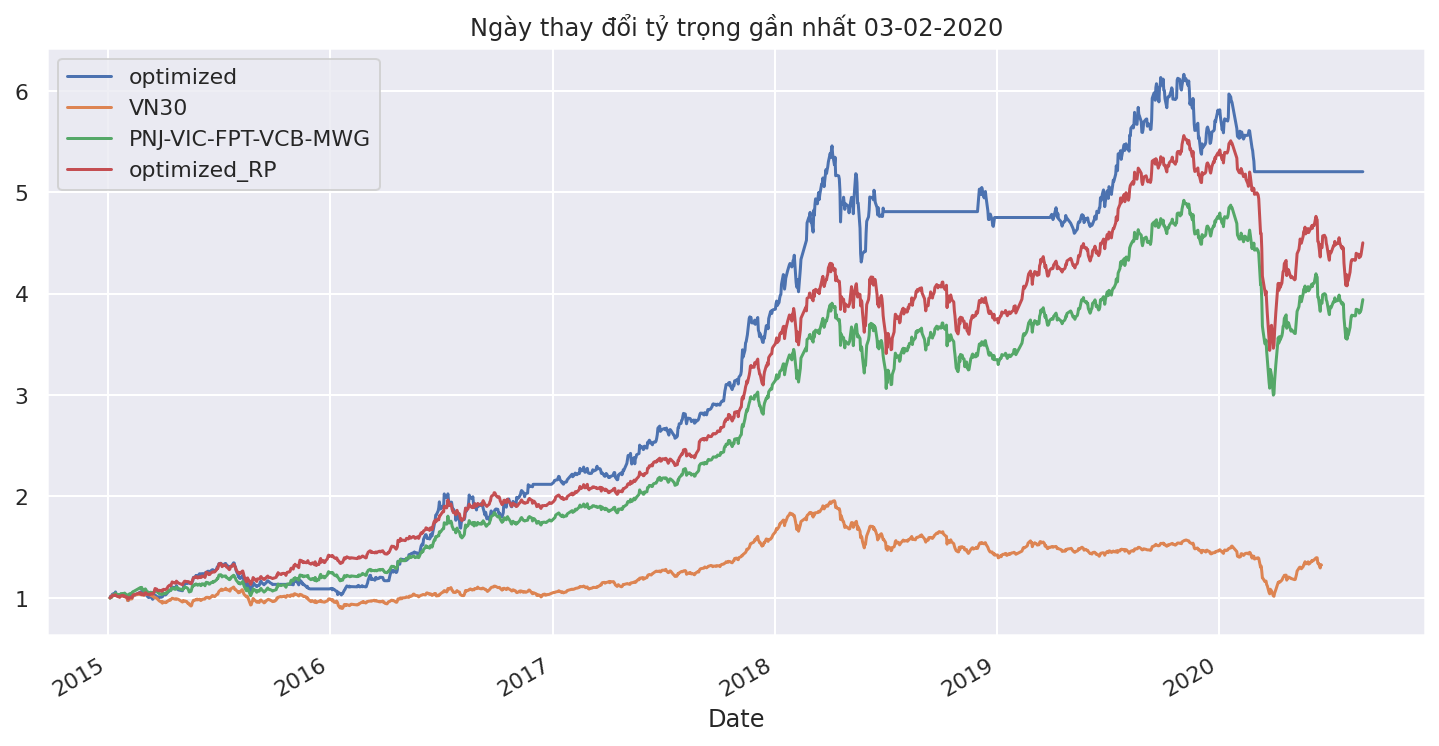

In [1084]:
last_reb_date = weights_dfs.Date.max().strftime('%d-%m-%Y')  #, %r
(combine_portfolio+1).cumprod().plot(title="Ngày thay đổi tỷ trọng gần nhất {}".format(last_reb_date))

fig1 = plt.gcf()
fig1.set_size_inches(11,6)
fig1.savefig('mkw.jpg',dpi=120,bbox_inches='tight')

                   weights  Uni  Month  Year
Date       Ticker                           
2019-04-01 VCB     0.60962    1      4  2019
           VIC     0.39038    1      4  2019
2019-05-01 FPT     0.15378    1      5  2019
           VCB     0.74383    1      5  2019
           VIC     0.10238    1      5  2019
2019-06-03 FPT     0.29860    1      6  2019
           VCB     0.61685    1      6  2019
           VIC     0.08455    1      6  2019
2019-07-01 FPT     0.41975    1      7  2019
           MWG     0.04809    1      7  2019
           VCB     0.53216    1      7  2019
2019-08-01 FPT     0.18225    1      8  2019
           MWG     0.41531    1      8  2019
           VCB     0.40244    1      8  2019
2019-09-02 FPT     0.09786    1      9  2019
           MWG     0.75749    1      9  2019
           VIC     0.14465    1      9  2019
2019-10-01 FPT     0.04034    1     10  2019
           MWG     0.80000    1     10  2019
           VCB     0.03512    1     10  2019
          

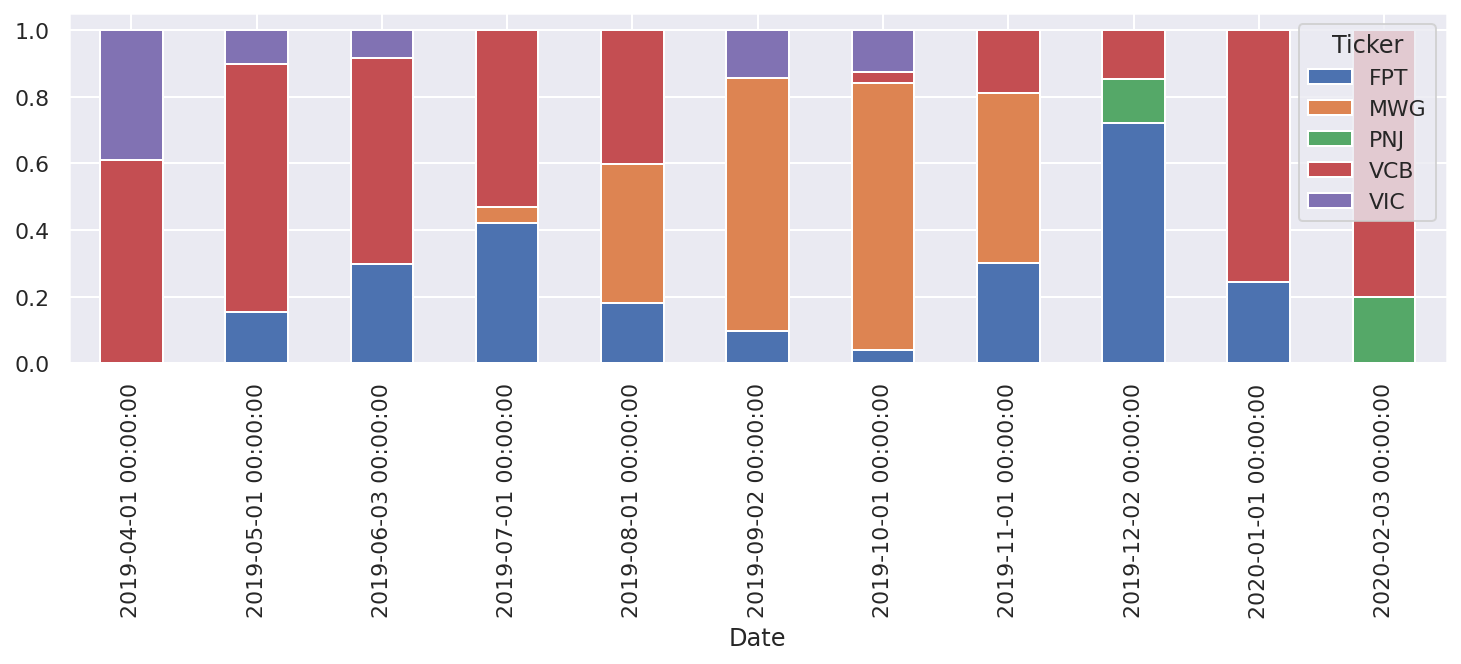

In [1085]:
#strftime('%d-%m-%Y')
reb_plot =weights_dfs[weights_dfs['Date'].between('2019-01-01', weights_dfs['Date'].max())].set_index(['Date', 'Ticker'])
reb_plot['weights'].unstack().plot.bar(figsize =(17, 5),stacked=True)
print(reb_plot)
#print(reb_plot.index.get_level_values(0).strftime('%d-%m-%Y'))
#weights_dfs
fig2 = plt.gcf()
fig2.set_size_inches(11,3)
fig2.savefig('mkw_allocation.jpg',dpi=120,bbox_inches='tight')

                   weights_RP  Uni_RP  Month  Year
Date       Ticker                                 
2019-01-01 FPT       0.220582       1      1  2019
           MWG       0.152993       1      1  2019
           PNJ       0.150625       1      1  2019
           VCB       0.222398       1      1  2019
           VIC       0.253402       1      1  2019
...                       ...     ...    ...   ...
2020-08-03 FPT       0.220192       1      8  2020
           MWG       0.163173       1      8  2020
           PNJ       0.160840       1      8  2020
           VCB       0.189724       1      8  2020
           VIC       0.266071       1      8  2020

[100 rows x 4 columns]


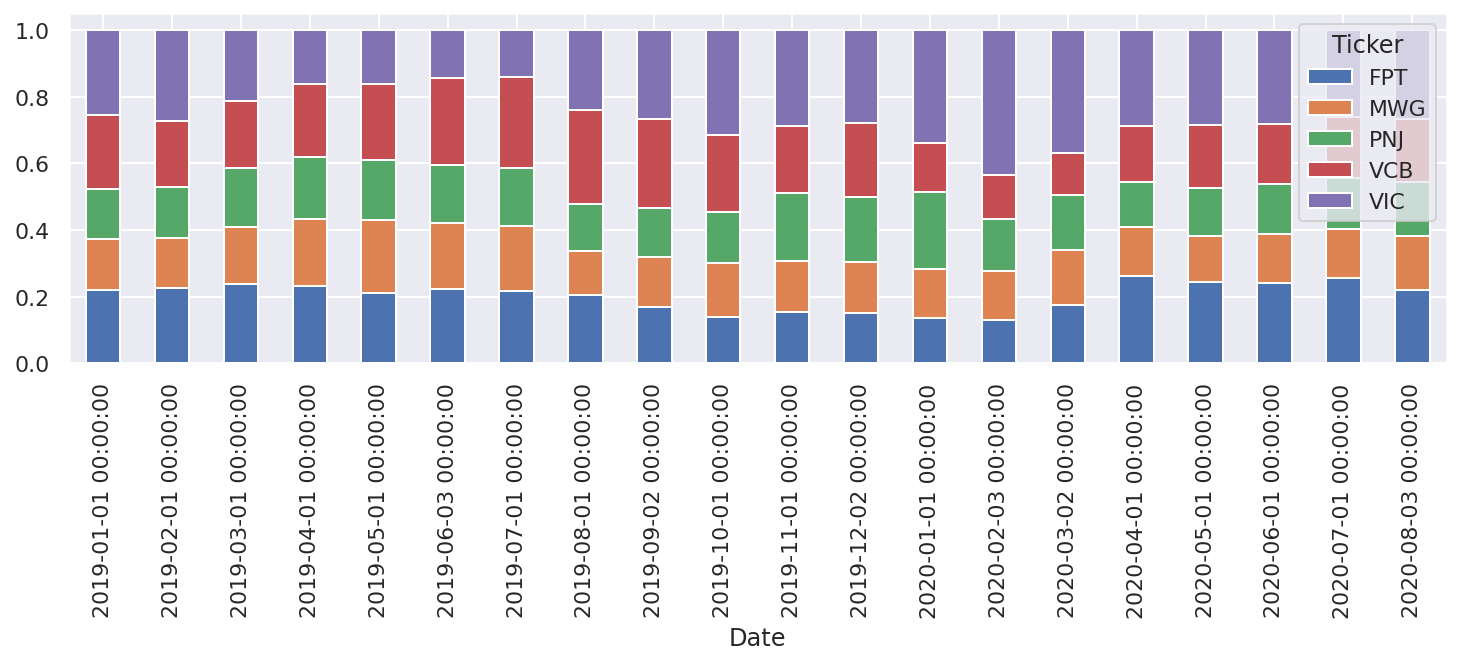

In [1086]:
reb_RP_plot =weights_RP_dfs[weights_RP_dfs['Date'].between('2019-01-01', weights_RP_dfs['Date'].max())].set_index(['Date', 'Ticker'])
reb_RP_plot['weights_RP'].unstack().plot.bar(figsize =(17, 5),stacked=True)
print(reb_RP_plot)
fig3 = plt.gcf()
fig3.set_size_inches(11,3)
fig3.savefig('RP_allocation.jpg',dpi=120,bbox_inches='tight')

In [1087]:

#weights_dfs.to_csv("vn30_optimized_weights.csv")
#weights_dfs.tail(30)

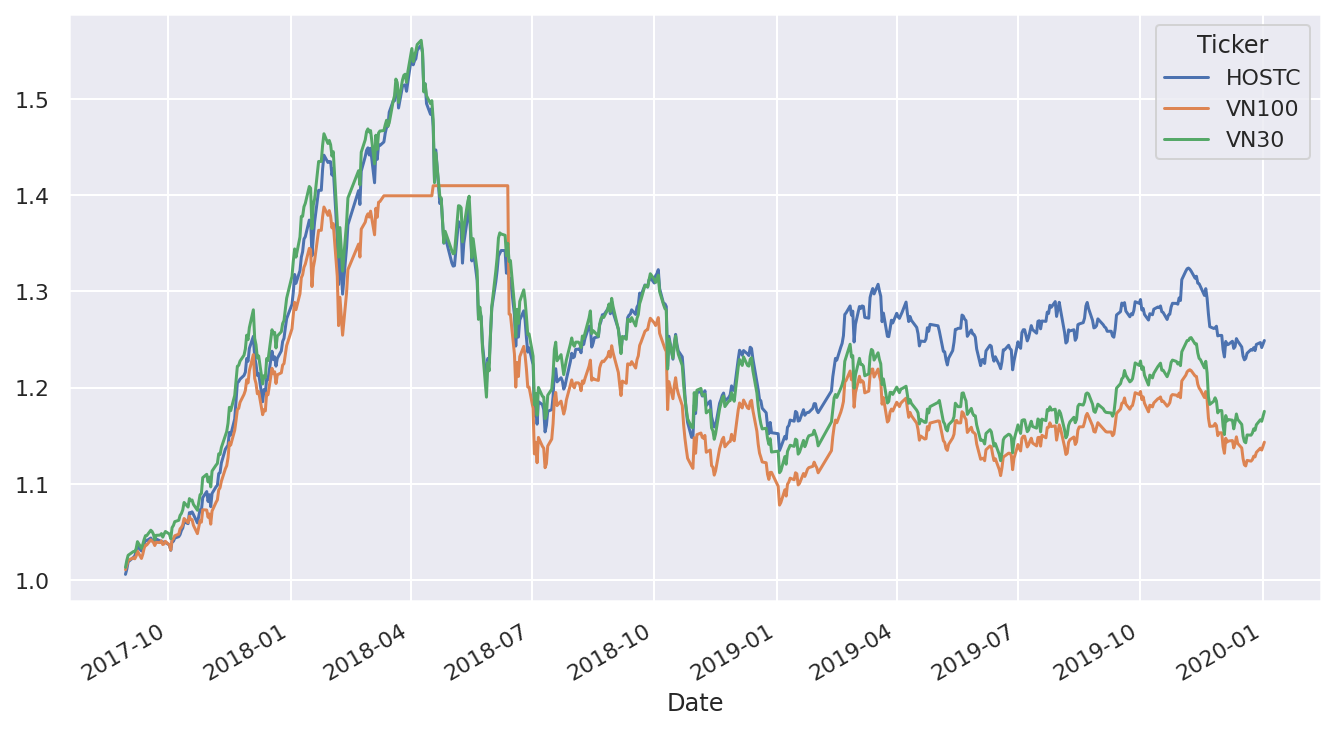

In [1088]:
# so sánh index
index_price = pd.read_excel('/content/drive/My Drive/data_analyst/index_price.xlsx')[['Date','Ticker', 'Close']]
index_pivot = index_price.pivot(index="Date", columns="Ticker", values="Close")
index_pivot = index_pivot['2017-08-29':'2020-01-02'][['HOSTC', 'VN100', 'VN30']]
index_pivot
return_index = index_pivot.pct_change()
#return_index['VN100'].dropna()
cum_ret = (return_index + 1).cumprod().dropna()
cum_ret.plot()
#return_index[['HOSTC', 'VN100', 'VN30', 'VNALL']].cumprod()

In [1089]:
#end 

In [1090]:
#firebase 
import datetime
import threading
from time import sleep

import requests
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore
from firebase_admin import storage

# Use a service account

# cred = credentials.Certificate("/content/drive/My Drive/data_analyst/service-key-flask-api.json")

# cred = credentials.Certificate("/content/drive/My Drive/data_analyst/service-key.json") #real-time-db
# firebase_admin.initialize_app(cred, {
#     'storageBucket': 'test-realtime-db-ca644.appspot.com'
# })
# db = firestore.client()
# bucket = storage.bucket()

In [1091]:
# xử lý weights để push lên
weights_dfs
weight_push = weights_dfs[weights_dfs['Date'] == weights_dfs.Date.max()][['Ticker', 'weights']].set_index('Ticker')
weight_dict = weight_push.to_dict()
weight_dict['weights']

{'PNJ': 0.2, 'VCB': 0.8}

In [1092]:
doc_ref = db.collection('list1').document('weights')
doc_ref.set(
    weight_dict['weights']
)

update_time {
  seconds: 1599589756
  nanos: 593436000
}

In [1093]:
imageBlob = bucket.blob("mkw.jpg")
imageBlob.upload_from_filename("/content/mkw.jpg")
print(imageBlob.public_url)

imageBlob2 = bucket.blob("mkw_allocation.jpg")
imageBlob2.upload_from_filename("/content/mkw_allocation.jpg")
print(imageBlob2.public_url)

https://storage.googleapis.com/test-realtime-db-ca644.appspot.com/mkw.jpg
https://storage.googleapis.com/test-realtime-db-ca644.appspot.com/mkw_allocation.jpg


In [1094]:
doc_ref = db.collection('lists')
docs = doc_ref.stream()

for doc in docs:
    print(f'{doc.id} => {doc.to_dict()}')

1 => {'user_id': 1, 'name': 'Blah', 'rebnum': 4, 'created_date': '2020-09-07', 'rebalance': True}
list1 => {'user_id': 1, 'rebalance': True, 'name': 'LTI', 'weights': {'VCB': 0.3}, 'rebnum': 3, 'created_date': '2020-09-07'}
list2 => {'user_id': 2, 'created_date': '2020-09-07', 'name': 'Blah'}
list3 => {'user_id': 1, 'name': 'Blah', 'created_date': '2020-09-07', 'rebalance': True, 'rebnum': 4}
stock-item1 => {'item1': 'VCB', 'item2': 'DHG'}


In [1095]:
# đang làm
class City(object):
    def __init__(self, name, user_id, created_date, rebalance=False, rebnum=0,
                 weights={}):
        self.name = name
        self.user_id = user_id
        self.created_date = created_date
        self.rebalance = rebalance
        self.rebnum = rebnum
        self.weights = weights

    @staticmethod
    def from_dict(source):
        # [START_EXCLUDE]
        city = City(source['name'], source['user_id'], source['created_date'])

        if 'rebalance' in source:
            city.rebalance = source['rebalance']

        if 'rebnum' in source:
            city.rebnum = source['rebnum']

        if 'weights' in source:
            city.weights = source['weights']

        return city
        # [END_EXCLUDE]

    def to_dict(self):
        # [START_EXCLUDE]
        dest = {
            'name': self.name,
            'user_id': self.user_id,
            'created_date': self.created_date
        }

        if self.rebalance:
            dest['rebalance'] = self.rebalance

        if self.rebnum:
            dest['rebnum'] = self.rebnum

        if self.weights:
            dest['weights'] = self.weights

        return dest
        # [END_EXCLUDE]

    def __repr__(self):
        return(
            f'City(\
                name={self.name}, \
                created_date={self.created_date}, \
                rebnum={self.rebnum}, \
                rebalance={self.rebalance}, \
                weights={self.weights}\
            )'
        )
# [END custom_class_def]


def add_example_data():
    #db = firestore.Client()
    # [START add_example_data]
    cities_ref = db.collection(u'lists')
    cities_ref.document('list1').set(
        City('LTI', 1, u'2020-09-07', True, 3, {"VCB": 0.3}).to_dict())
    cities_ref.document('list2').set(
        City('Blah', 2, '2020-09-07', False, 0,
             {}).to_dict())
    cities_ref.document('list3').set(
        City('Blah', 1, '2020-09-07', True, 4,
             {}).to_dict())
    cities_ref.document('1').set(
        City('Blah', 1, '2020-09-07', True, 4,
             {}).to_dict())    
    # [END add_example_data]
add_example_data() 

In [1096]:
from scipy.optimize import minimize
TOLERANCE = 1e-10


def _allocation_risk(weights, covariances):

    # We calculate the risk of the weights distribution
    portfolio_risk = np.sqrt((weights * covariances * weights.T))[0, 0]

    # It returns the risk of the weights distribution
    return portfolio_risk


def _assets_risk_contribution_to_allocation_risk(weights, covariances):

    # We calculate the risk of the weights distribution
    portfolio_risk = _allocation_risk(weights, covariances)

    # We calculate the contribution of each asset to the risk of the weights
    # distribution
    assets_risk_contribution = np.multiply(weights.T, covariances * weights.T) \
        / portfolio_risk

    # It returns the contribution of each asset to the risk of the weights
    # distribution
    return assets_risk_contribution


def _risk_budget_objective_error(weights, args):

    # The covariance matrix occupies the first position in the variable
    covariances = args[0]

    # The desired contribution of each asset to the portfolio risk occupies the
    # second position
    assets_risk_budget = args[1]

    # We convert the weights to a matrix
    weights = np.matrix(weights)

    # We calculate the risk of the weights distribution
    portfolio_risk = _allocation_risk(weights, covariances)

    # We calculate the contribution of each asset to the risk of the weights
    # distribution
    assets_risk_contribution = \
        _assets_risk_contribution_to_allocation_risk(weights, covariances)

    # We calculate the desired contribution of each asset to the risk of the
    # weights distribution
    assets_risk_target = \
        np.asmatrix(np.multiply(portfolio_risk, assets_risk_budget))

    # Error between the desired contribution and the calculated contribution of
    # each asset
    error = \
        sum(np.square(assets_risk_contribution - assets_risk_target.T))[0, 0]

    # It returns the calculated error
    return error


def _get_risk_parity_weights(covariances, assets_risk_budget, initial_weights):

    # Restrictions to consider in the optimisation: only long positions whose
    # sum equals 100%
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0},
                   {'type': 'ineq', 'fun': lambda x: x})

    # Optimisation process in scipy
    optimize_result = minimize(fun=_risk_budget_objective_error,
                               x0=initial_weights,
                               args=[covariances, assets_risk_budget],
                               method='SLSQP',
                               constraints=constraints,
                               tol=TOLERANCE,
                               options={'disp': False})

    # Recover the weights from the optimised object
    weights = optimize_result.x

    # It returns the optimised weights
    return weights


def get_weights(df):

    # We download the prices from Yahoo Finance
    prices = df.copy()

    # We calculate the covariance matrix
    covariances = 52.0 * \
        prices.asfreq('W-FRI').pct_change().iloc[1:, :].cov().values

    # The desired contribution of each asset to the portfolio risk: we want all
    # asset to contribute equally
    assets_risk_budget = [1 / prices.shape[1]] * prices.shape[1]

    # Initial weights: equally weighted
    init_weights = [1 / prices.shape[1]] * prices.shape[1]

    # Optimisation process of weights
    weights = \
        _get_risk_parity_weights(covariances, assets_risk_budget, init_weights)

    # Convert the weights to a pandas Series
    weights = pd.Series(weights, index=prices.columns, name='weight')

    # It returns the optimised weights
    return weights


In [1097]:
import pandas_datareader.data as web
yahoo_tickers=['GOOGL', 'AAPL', 'AMZN']
start_date=datetime.datetime(2016, 10, 31)
end_date=datetime.datetime(2017, 10, 31)
prices = pd.DataFrame([web.DataReader(t,
                                          'yahoo',
                                          start_date,
                                          end_date).loc[:, 'Adj Close']
                           for t in yahoo_tickers],
                          index=yahoo_tickers).T.asfreq('B').ffill()

In [1098]:
prices

,GOOGL,AAPL,AMZN
Date,,,
2016-10-31,809.900024,26.791819,789.820007
2016-11-01,805.479980,26.308084,785.409973
2016-11-02,788.419983,26.331680,765.559998
2016-11-03,782.190002,26.049444,767.030029
2016-11-04,781.099976,25.814631,755.049988
...,...,...,...
2017-10-25,991.460022,37.558807,972.909973
2017-10-26,991.419983,37.798935,972.429993
2017-10-27,1033.670044,39.153267,1100.949951


In [1099]:
risk_parity_weights = get_weights(df)
risk_parity_weights

Ticker
FPT    0.220192
MWG    0.163173
PNJ    0.160840
VCB    0.189724
VIC    0.266071
Name: weight, dtype: float64

In [1100]:
c = risk_parity_weights
c = pd.DataFrame(c).reset_index().rename(columns={'weight': 'weights_RP'})
c

,Ticker,weights_RP
0,FPT,0.220192
1,MWG,0.163173
2,PNJ,0.160840
3,VCB,0.189724
4,VIC,0.266071


In [1101]:
weights_RP_dfs

,Ticker,weights_RP,Date,Uni_RP,Month,Year
0,FPT,0.216435,2015-01-01,1,1,2015
1,PNJ,0.281449,2015-01-01,1,1,2015
2,VCB,0.211446,2015-01-01,1,1,2015
3,VIC,0.290670,2015-01-01,1,1,2015
0,FPT,0.290014,2015-02-02,1,2,2015
...,...,...,...,...,...,...
0,FPT,0.220192,2020-08-03,1,8,2020
1,MWG,0.163173,2020-08-03,1,8,2020
2,PNJ,0.160840,2020-08-03,1,8,2020
3,VCB,0.189724,2020-08-03,1,8,2020


In [1102]:
combine_portfolio

,optimized,VN30,PNJ-VIC-FPT-VCB-MWG,optimized_RP
Date,,,,
2015-01-05,0.000000,-0.003274,-0.003589,0.000000
2015-01-06,0.015612,0.011139,0.011242,0.010842
2015-01-07,-0.004889,0.002111,-0.005228,-0.001746
2015-01-08,0.010870,-0.001317,0.006518,0.005164
2015-01-09,0.014105,0.019049,0.013243,0.008140
...,...,...,...,...
2020-08-18,0.000000,NaN,-0.007468,-0.007658
2020-08-19,0.000000,NaN,0.003769,0.003288
2020-08-20,0.000000,NaN,-0.000547,-0.000797
